In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

%load_ext autoreload
%autoreload 2

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
tb=SummaryWriter()
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [4]:
bs = 32
# Load Data
train_dataset = datasets.ImageFolder(root='./No_Image_Preprocessing_Pattern1/Training/Normal', transform=transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(), 
]))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=False)
len(train_dataset.imgs), len(train_dataloader)
train_dataset

Dataset ImageFolder
    Number of datapoints: 256
    Root location: ./No_Image_Preprocessing_Pattern1/Training/Normal
    StandardTransform
Transform: Compose(
               Resize(size=128, interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

In [5]:
len(train_dataloader)

8

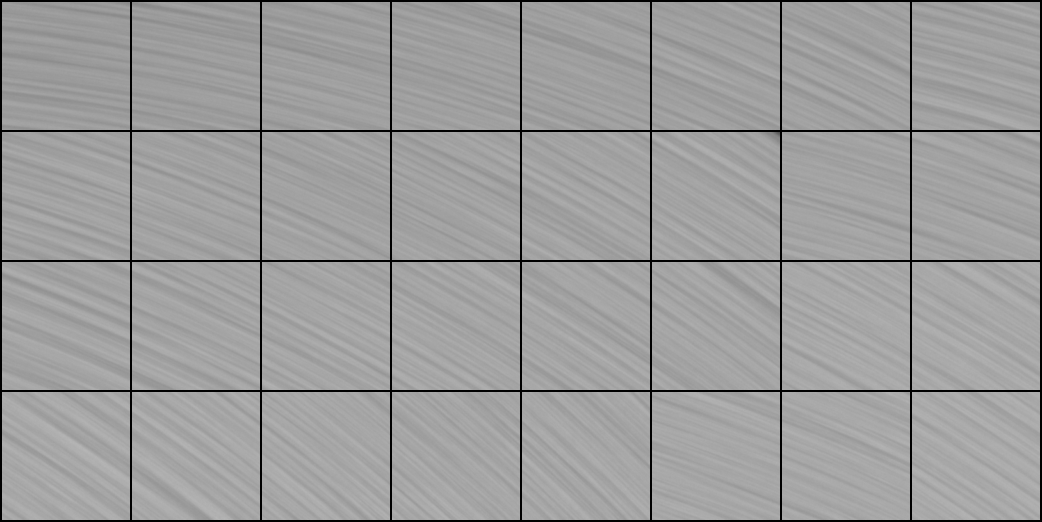

In [6]:
# Fixed input for debugging
fixed_x, _ = next(iter(train_dataloader))
save_image(fixed_x, 'AE_Normal_training.png')
Image('AE_Normal_training.png')

In [7]:
dataloader_iterator = iter(train_dataloader)
for i in range(len(train_dataloader)):
    try:
        data, target = next(dataloader_iterator)
        save_image(data, './No_Image_Preprocessing_Pattern1/Original/Training_Image_{}.png'.format(i))
    except StopIteration:
        dataloader_iterator = iter(dataloader)
        data, target = next(dataloader_iterator)

In [8]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [9]:
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [10]:
class autoencoder(nn.Module):
    def __init__(self,i=1024,o=64):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=2, stride=2),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(512, 1024, kernel_size=2, stride=2),
            nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=2, stride=2),
            nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            Flatten(),
            nn.Linear(in_features=i, out_features=o),
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=o, out_features=i),
            UnFlatten(),
            nn.ConvTranspose2d(1024, 1024, kernel_size=2, stride=2),
            nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2),
            nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [11]:
model= autoencoder()
model.to(device)

autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(256, 512, kernel_size=(2, 2), stride=(2, 2))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(512, 1024, kernel_size=(2, 2), stride=(2, 2))
    (16): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, t

In [12]:
## show input shape
summary(model,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             416
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 32, 32]           8,256
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 16, 16]          32,896
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10            [-1, 256, 8, 8]         131,328
      BatchNorm2d-11            [-1, 256, 8, 8]             512
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 512, 4, 4]         524,800
      BatchNorm2d-14            [-1, 51

In [13]:
def to_img(x):
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 128, 128)
    return x

In [14]:
num_epochs = 3000
learning_rate = 1e-3
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [15]:
for epoch in range(num_epochs):
    for data in train_dataloader:
        img, _ = data
        img = Variable(img).cuda()
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.data))
    tb.add_scalar("Loss/Epoch", loss.data, epoch+1)
    if epoch % 100 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, './No_Image_Preprocessing_Pattern1/Reconstructed/AE/AE_latent64_{}.png'.format(epoch))

torch.save(model.state_dict(), './autoencoder_AE_Thesis_Pattern1_latent64.pth')

epoch [1/3000], loss:35691.0625
epoch [2/3000], loss:33716.6602
epoch [3/3000], loss:31842.1797
epoch [4/3000], loss:30204.5078
epoch [5/3000], loss:29085.6504
epoch [6/3000], loss:28145.8340
epoch [7/3000], loss:27245.9551
epoch [8/3000], loss:26428.8789
epoch [9/3000], loss:25653.2422
epoch [10/3000], loss:24902.0430
epoch [11/3000], loss:24179.6484
epoch [12/3000], loss:23485.2910
epoch [13/3000], loss:22811.7500
epoch [14/3000], loss:22155.3555
epoch [15/3000], loss:21520.7188
epoch [16/3000], loss:20903.3008
epoch [17/3000], loss:20302.7598
epoch [18/3000], loss:19717.7656
epoch [19/3000], loss:19148.4395
epoch [20/3000], loss:18594.4746
epoch [21/3000], loss:18055.7051
epoch [22/3000], loss:17531.6758
epoch [23/3000], loss:17021.2578
epoch [24/3000], loss:16526.7617
epoch [25/3000], loss:16045.8740
epoch [26/3000], loss:15578.2598
epoch [27/3000], loss:15124.0479
epoch [28/3000], loss:14682.9814
epoch [29/3000], loss:14254.1992
epoch [30/3000], loss:13837.8809
epoch [31/3000], lo

epoch [252/3000], loss:1093.6437
epoch [253/3000], loss:1091.6443
epoch [254/3000], loss:1094.8418
epoch [255/3000], loss:1090.1212
epoch [256/3000], loss:1093.5813
epoch [257/3000], loss:1093.0166
epoch [258/3000], loss:1091.9426
epoch [259/3000], loss:1094.8528
epoch [260/3000], loss:1090.3309
epoch [261/3000], loss:1091.4988
epoch [262/3000], loss:1091.3209
epoch [263/3000], loss:1090.2190
epoch [264/3000], loss:1093.0092
epoch [265/3000], loss:1090.2422
epoch [266/3000], loss:1090.9464
epoch [267/3000], loss:1096.0635
epoch [268/3000], loss:1091.8976
epoch [269/3000], loss:1094.5925
epoch [270/3000], loss:1095.6602
epoch [271/3000], loss:1092.9662
epoch [272/3000], loss:1094.7522
epoch [273/3000], loss:1093.6409
epoch [274/3000], loss:1094.9397
epoch [275/3000], loss:1091.1027
epoch [276/3000], loss:1089.5007
epoch [277/3000], loss:1089.3917
epoch [278/3000], loss:1089.5913
epoch [279/3000], loss:1089.2572
epoch [280/3000], loss:1090.5885
epoch [281/3000], loss:1090.9415
epoch [282

epoch [507/3000], loss:646.7453
epoch [508/3000], loss:643.5533
epoch [509/3000], loss:642.0485
epoch [510/3000], loss:634.8516
epoch [511/3000], loss:638.1958
epoch [512/3000], loss:634.9967
epoch [513/3000], loss:650.8367
epoch [514/3000], loss:642.5535
epoch [515/3000], loss:632.5724
epoch [516/3000], loss:631.4268
epoch [517/3000], loss:636.0268
epoch [518/3000], loss:645.2239
epoch [519/3000], loss:626.3685
epoch [520/3000], loss:632.2581
epoch [521/3000], loss:612.7147
epoch [522/3000], loss:619.1711
epoch [523/3000], loss:604.0489
epoch [524/3000], loss:601.3655
epoch [525/3000], loss:598.6200
epoch [526/3000], loss:603.7150
epoch [527/3000], loss:600.8898
epoch [528/3000], loss:599.6898
epoch [529/3000], loss:595.8750
epoch [530/3000], loss:597.5145
epoch [531/3000], loss:595.6747
epoch [532/3000], loss:611.0853
epoch [533/3000], loss:600.4658
epoch [534/3000], loss:592.4088
epoch [535/3000], loss:586.3861
epoch [536/3000], loss:595.4001
epoch [537/3000], loss:594.8696
epoch [5

epoch [764/3000], loss:247.8676
epoch [765/3000], loss:257.1962
epoch [766/3000], loss:247.5702
epoch [767/3000], loss:259.5629
epoch [768/3000], loss:255.7816
epoch [769/3000], loss:252.3242
epoch [770/3000], loss:249.0432
epoch [771/3000], loss:251.0572
epoch [772/3000], loss:246.6634
epoch [773/3000], loss:241.3741
epoch [774/3000], loss:241.1800
epoch [775/3000], loss:240.8346
epoch [776/3000], loss:238.5843
epoch [777/3000], loss:239.2000
epoch [778/3000], loss:238.9885
epoch [779/3000], loss:238.2657
epoch [780/3000], loss:236.6371
epoch [781/3000], loss:237.8027
epoch [782/3000], loss:234.2364
epoch [783/3000], loss:235.4218
epoch [784/3000], loss:234.1460
epoch [785/3000], loss:236.0543
epoch [786/3000], loss:232.4074
epoch [787/3000], loss:237.5974
epoch [788/3000], loss:235.8789
epoch [789/3000], loss:235.3219
epoch [790/3000], loss:235.8514
epoch [791/3000], loss:234.5633
epoch [792/3000], loss:236.9274
epoch [793/3000], loss:237.5744
epoch [794/3000], loss:237.2039
epoch [7

epoch [1020/3000], loss:220.2023
epoch [1021/3000], loss:219.8944
epoch [1022/3000], loss:221.3043
epoch [1023/3000], loss:220.6831
epoch [1024/3000], loss:220.4541
epoch [1025/3000], loss:214.8089
epoch [1026/3000], loss:221.3383
epoch [1027/3000], loss:215.1920
epoch [1028/3000], loss:215.7615
epoch [1029/3000], loss:214.9435
epoch [1030/3000], loss:216.9009
epoch [1031/3000], loss:211.0648
epoch [1032/3000], loss:213.5266
epoch [1033/3000], loss:212.5148
epoch [1034/3000], loss:212.8080
epoch [1035/3000], loss:212.4677
epoch [1036/3000], loss:210.3359
epoch [1037/3000], loss:211.9540
epoch [1038/3000], loss:212.9007
epoch [1039/3000], loss:211.9562
epoch [1040/3000], loss:213.0803
epoch [1041/3000], loss:209.6847
epoch [1042/3000], loss:215.9022
epoch [1043/3000], loss:211.4902
epoch [1044/3000], loss:210.4279
epoch [1045/3000], loss:210.7630
epoch [1046/3000], loss:211.1761
epoch [1047/3000], loss:207.9099
epoch [1048/3000], loss:209.5963
epoch [1049/3000], loss:207.8602
epoch [105

epoch [1269/3000], loss:384.6697
epoch [1270/3000], loss:828.3829
epoch [1271/3000], loss:1191.0283
epoch [1272/3000], loss:1297.4854
epoch [1273/3000], loss:1270.8431
epoch [1274/3000], loss:1237.0638
epoch [1275/3000], loss:1218.1371
epoch [1276/3000], loss:1193.1184
epoch [1277/3000], loss:1102.6923
epoch [1278/3000], loss:1043.6130
epoch [1279/3000], loss:997.5021
epoch [1280/3000], loss:979.8652
epoch [1281/3000], loss:959.3200
epoch [1282/3000], loss:937.5619
epoch [1283/3000], loss:921.8158
epoch [1284/3000], loss:906.2731
epoch [1285/3000], loss:966.7137
epoch [1286/3000], loss:955.6779
epoch [1287/3000], loss:980.0884
epoch [1288/3000], loss:948.2599
epoch [1289/3000], loss:884.7826
epoch [1290/3000], loss:906.2997
epoch [1291/3000], loss:836.6668
epoch [1292/3000], loss:805.0413
epoch [1293/3000], loss:803.0848
epoch [1294/3000], loss:835.3837
epoch [1295/3000], loss:879.3093
epoch [1296/3000], loss:805.5065
epoch [1297/3000], loss:804.2028
epoch [1298/3000], loss:803.0225
ep

epoch [1518/3000], loss:209.6347
epoch [1519/3000], loss:213.3470
epoch [1520/3000], loss:210.7245
epoch [1521/3000], loss:214.6177
epoch [1522/3000], loss:216.7274
epoch [1523/3000], loss:211.1367
epoch [1524/3000], loss:216.0677
epoch [1525/3000], loss:217.2062
epoch [1526/3000], loss:216.8691
epoch [1527/3000], loss:346.6149
epoch [1528/3000], loss:293.6456
epoch [1529/3000], loss:284.9438
epoch [1530/3000], loss:253.7696
epoch [1531/3000], loss:255.9608
epoch [1532/3000], loss:236.0603
epoch [1533/3000], loss:233.6538
epoch [1534/3000], loss:216.4559
epoch [1535/3000], loss:220.2370
epoch [1536/3000], loss:212.0352
epoch [1537/3000], loss:220.2360
epoch [1538/3000], loss:218.1165
epoch [1539/3000], loss:214.1216
epoch [1540/3000], loss:210.8586
epoch [1541/3000], loss:208.3277
epoch [1542/3000], loss:210.6716
epoch [1543/3000], loss:203.9809
epoch [1544/3000], loss:209.6930
epoch [1545/3000], loss:203.2386
epoch [1546/3000], loss:208.1487
epoch [1547/3000], loss:206.8000
epoch [154

epoch [1767/3000], loss:170.6352
epoch [1768/3000], loss:174.2251
epoch [1769/3000], loss:174.0260
epoch [1770/3000], loss:177.0709
epoch [1771/3000], loss:176.8609
epoch [1772/3000], loss:177.3259
epoch [1773/3000], loss:177.0184
epoch [1774/3000], loss:176.2668
epoch [1775/3000], loss:174.1905
epoch [1776/3000], loss:176.6728
epoch [1777/3000], loss:183.7469
epoch [1778/3000], loss:176.1616
epoch [1779/3000], loss:176.7181
epoch [1780/3000], loss:173.5901
epoch [1781/3000], loss:174.7560
epoch [1782/3000], loss:169.9697
epoch [1783/3000], loss:170.6271
epoch [1784/3000], loss:171.9154
epoch [1785/3000], loss:169.8765
epoch [1786/3000], loss:168.9516
epoch [1787/3000], loss:168.6552
epoch [1788/3000], loss:170.8507
epoch [1789/3000], loss:170.7469
epoch [1790/3000], loss:164.2430
epoch [1791/3000], loss:161.8161
epoch [1792/3000], loss:167.9754
epoch [1793/3000], loss:142.8484
epoch [1794/3000], loss:138.2731
epoch [1795/3000], loss:148.7304
epoch [1796/3000], loss:135.2863
epoch [179

epoch [2018/3000], loss:51.3551
epoch [2019/3000], loss:54.3017
epoch [2020/3000], loss:53.5143
epoch [2021/3000], loss:52.6115
epoch [2022/3000], loss:53.4932
epoch [2023/3000], loss:52.3117
epoch [2024/3000], loss:51.0508
epoch [2025/3000], loss:52.7124
epoch [2026/3000], loss:52.3869
epoch [2027/3000], loss:50.7523
epoch [2028/3000], loss:54.0262
epoch [2029/3000], loss:53.9612
epoch [2030/3000], loss:55.0177
epoch [2031/3000], loss:54.8844
epoch [2032/3000], loss:53.2079
epoch [2033/3000], loss:53.2437
epoch [2034/3000], loss:53.6472
epoch [2035/3000], loss:54.8813
epoch [2036/3000], loss:55.8940
epoch [2037/3000], loss:52.1217
epoch [2038/3000], loss:50.9296
epoch [2039/3000], loss:53.5425
epoch [2040/3000], loss:54.7066
epoch [2041/3000], loss:56.0022
epoch [2042/3000], loss:53.5569
epoch [2043/3000], loss:53.3193
epoch [2044/3000], loss:54.5100
epoch [2045/3000], loss:53.1945
epoch [2046/3000], loss:51.6629
epoch [2047/3000], loss:51.1081
epoch [2048/3000], loss:49.2968
epoch [2

epoch [2274/3000], loss:46.4635
epoch [2275/3000], loss:46.9328
epoch [2276/3000], loss:47.2663
epoch [2277/3000], loss:46.5645
epoch [2278/3000], loss:45.4118
epoch [2279/3000], loss:46.3135
epoch [2280/3000], loss:47.3419
epoch [2281/3000], loss:50.3600
epoch [2282/3000], loss:49.8695
epoch [2283/3000], loss:49.2129
epoch [2284/3000], loss:52.6590
epoch [2285/3000], loss:48.4961
epoch [2286/3000], loss:47.6612
epoch [2287/3000], loss:48.4195
epoch [2288/3000], loss:47.4028
epoch [2289/3000], loss:52.9519
epoch [2290/3000], loss:50.8799
epoch [2291/3000], loss:49.8217
epoch [2292/3000], loss:51.7031
epoch [2293/3000], loss:50.1520
epoch [2294/3000], loss:53.0545
epoch [2295/3000], loss:50.7596
epoch [2296/3000], loss:52.9718
epoch [2297/3000], loss:57.8809
epoch [2298/3000], loss:50.8386
epoch [2299/3000], loss:50.0163
epoch [2300/3000], loss:51.6289
epoch [2301/3000], loss:50.0775
epoch [2302/3000], loss:49.1181
epoch [2303/3000], loss:49.5942
epoch [2304/3000], loss:52.0565
epoch [2

epoch [2531/3000], loss:38.2565
epoch [2532/3000], loss:36.3353
epoch [2533/3000], loss:38.2735
epoch [2534/3000], loss:42.6874
epoch [2535/3000], loss:39.4965
epoch [2536/3000], loss:38.1476
epoch [2537/3000], loss:37.5464
epoch [2538/3000], loss:37.0534
epoch [2539/3000], loss:37.4661
epoch [2540/3000], loss:37.0245
epoch [2541/3000], loss:37.8954
epoch [2542/3000], loss:37.1645
epoch [2543/3000], loss:36.0840
epoch [2544/3000], loss:37.6293
epoch [2545/3000], loss:37.0929
epoch [2546/3000], loss:36.8874
epoch [2547/3000], loss:39.4062
epoch [2548/3000], loss:36.9412
epoch [2549/3000], loss:37.5367
epoch [2550/3000], loss:40.0695
epoch [2551/3000], loss:39.7691
epoch [2552/3000], loss:38.2088
epoch [2553/3000], loss:40.7862
epoch [2554/3000], loss:43.4922
epoch [2555/3000], loss:38.5303
epoch [2556/3000], loss:38.9961
epoch [2557/3000], loss:38.2145
epoch [2558/3000], loss:37.6614
epoch [2559/3000], loss:38.2725
epoch [2560/3000], loss:40.5563
epoch [2561/3000], loss:41.6186
epoch [2

epoch [2787/3000], loss:32.7250
epoch [2788/3000], loss:32.6782
epoch [2789/3000], loss:34.7574
epoch [2790/3000], loss:33.4602
epoch [2791/3000], loss:33.7556
epoch [2792/3000], loss:34.2669
epoch [2793/3000], loss:35.2197
epoch [2794/3000], loss:34.2556
epoch [2795/3000], loss:35.6255
epoch [2796/3000], loss:36.5797
epoch [2797/3000], loss:37.2963
epoch [2798/3000], loss:35.4600
epoch [2799/3000], loss:36.4566
epoch [2800/3000], loss:37.7041
epoch [2801/3000], loss:34.1911
epoch [2802/3000], loss:33.4387
epoch [2803/3000], loss:40.2537
epoch [2804/3000], loss:48.9905
epoch [2805/3000], loss:47.4207
epoch [2806/3000], loss:44.9209
epoch [2807/3000], loss:38.7028
epoch [2808/3000], loss:38.2608
epoch [2809/3000], loss:39.2127
epoch [2810/3000], loss:35.9685
epoch [2811/3000], loss:34.3057
epoch [2812/3000], loss:34.7054
epoch [2813/3000], loss:34.1634
epoch [2814/3000], loss:32.4123
epoch [2815/3000], loss:32.8050
epoch [2816/3000], loss:32.8323
epoch [2817/3000], loss:31.8930
epoch [2

In [16]:
tb.flush()